# Inspect Trained Model (predictions + gradcam)

Init train dataset with 3875 PNEUMONIA images and 1341 NORMAL images.
Init test dataset with 390 PNEUMONIA images and 234 NORMAL images.


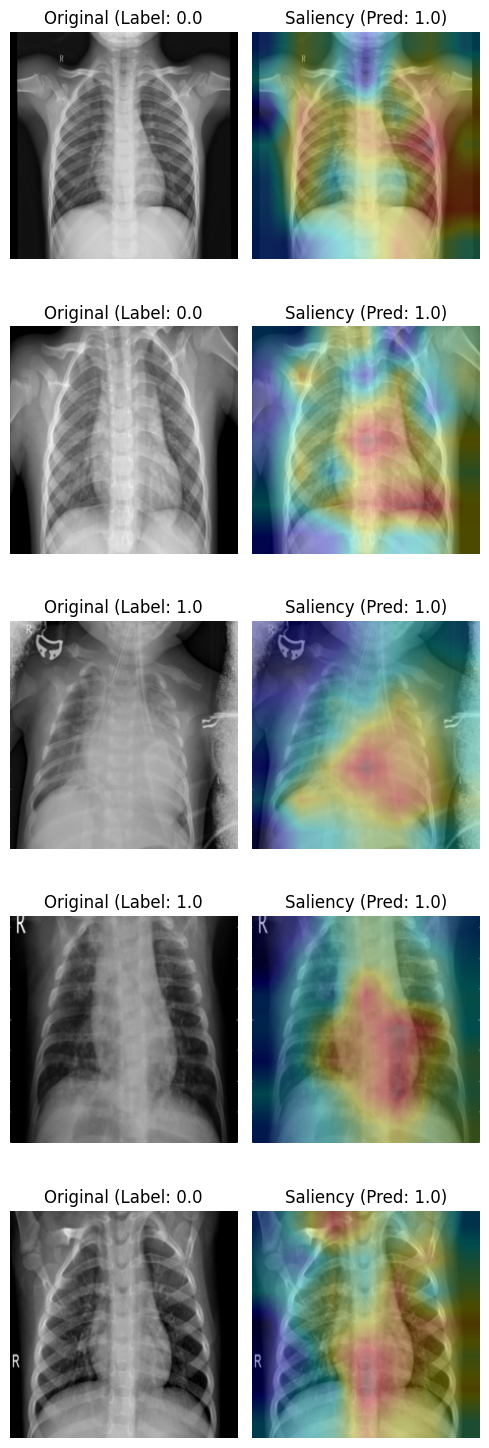

In [9]:
import datamodule
import models
import saliency
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np
import cv2
import matplotlib.pyplot as plt
from utils import BaseConfig
import torch

reload(datamodule)
reload(models)
reload(saliency)

PATH_TO_CKPT = "/home/brimax/repos/medimg-saliency-benchmark/medimg-saliency-benchmark/checkpoints/rn_True_False_0.54.ckpt"
ALPHA = 0.3
N = 5  # Number of images to sample
device = "cuda" if torch.cuda.is_available() else "cpu"

def overlay_gradcam_on_image(img_tensor, cam, alpha=0.5):
    # img_tensor: shape [1, 3, H, W] (unnormalized, float [0,1])
    img_np = img_tensor.squeeze(0).detach().cpu().numpy()  # [3, H, W]
    img_np = np.transpose(img_np, (1, 2, 0))      # [H, W, 3]
    img_np = (img_np * 255).astype(np.uint8)

    # Resize cam to match image size
    cam_resized = cv2.resize(cam, (img_np.shape[1], img_np.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Blend heatmap with original image
    overlay = cv2.addWeighted(img_np, 1 - alpha, heatmap, alpha, 0)
    return overlay

config = BaseConfig("./config.json")
dm = datamodule.Datamodule(config)
dm.setup()
dl = dm.test_dataloader()

# Sample N random indices
indices = np.random.choice(len(dm.test_ds), N, replace=False)
# indices = np.arange(390, 309+N)
# Fetch the corresponding batch of images
images = []
labels = []
for idx in indices:
    X, y = dm.test_ds[idx]
    images.append(X)
    labels.append(y)

# Convert lists to tensors
X = torch.stack(images).to(device)
y = torch.tensor(labels).to(device)

model = models.BaseCNN.load_from_checkpoint(PATH_TO_CKPT).to(device)
model.eval()
pred = model.predict(X)

gcam = saliency.CAM(model.model)
cams = []

for i in range(N):
    single_cam = gcam(X[[i]])  # Add batch dimension with X[[i]]
    cams.append(single_cam)
# Plotting
fig, axes = plt.subplots(N, 2, figsize=(5, 3*N))  # Adjust figure size as needed

for i in range(N):
    # Original Image
    img = X[i].permute(1, 2, 0).cpu().numpy()
    img = (img * 255).astype(np.uint8)
    axes[i, 0].imshow(img)
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f"Original (Label: {y[i].item()}")

    # GradCAM Overlay
    overlay = overlay_gradcam_on_image(X[i:i+1], cams[i], alpha=ALPHA)
    axes[i, 1].imshow(overlay)
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f"Saliency (Pred: {pred[i].item()})")

plt.tight_layout()
plt.show()

# Parse the content of the .json in /evaluation/ and write to a .csv

In [55]:
# Parse the results to write in a nice latex table
import json
import os

# Parse the JSON file
def parse_json_and_format_for_latex(json_data):
    # Load the JSON data
    data = json_data
    
    # Extract the results
    results = data["results"][0]
    
    # Format the metrics with confidence intervals
    # We'll round to 3 decimal places and format as "mean ± half_width"
    metrics = {}
    
    # Calculate and format each metric
    metrics_name = set(k.replace("test/", "").split("_")[0]for k in results.keys())

    for name in metrics_name:
        metrics[name] = {
            "mean": results[f'test/{name}_mean'],
            "pm": (results[f'test/{name}_ci_upper'] - results[f'test/{name}_ci_lower'])/2
        }
    return metrics

payload = "model,linear,pretrained"


for i, evals in enumerate(sorted(os.listdir("evaluation"))):
    
    # Opne json
    with open(f"evaluation/{evals}", "r") as f:
        res = json.load(f)

    # Format csv row
    model, linear, pretrained = evals.split("_")[:3]
    metrics = parse_json_and_format_for_latex(res)

    # Add header 
    if i == 0:
        for name in metrics.keys():
            payload += f",{name},pm"
        payload += "\n"

    # Add values
    payload += f"{model},{linear},{pretrained}"
    for name in metrics.keys():
        mean = metrics[name]["mean"] * 100
        pm = metrics[name]["pm"] * 100
        payload += f",{mean},{pm}"
    payload+="\n"

# Dump to csv
with open("plots/results.csv", "w") as f:
    f.write(payload)

# Read .csv with results and create latex table

In [71]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('plots/results.csv')

# Process the data to restructure it
# Map "linear" column to "Adapted Classifier" for the table
df['adapted_classifier'] = df['linear'].map({True: 'Yes', False: 'No'})
df['pretrained_text'] = df['pretrained'].map({True: 'Yes', False: 'No'})

# Format metrics with their plus/minus values
metrics = ['accuracy', 'f1', 'auroc']  # Changed to use accuracy and f1 instead of precision and recall
for i, row in df.iterrows():
    for metric in metrics:
        # Assuming the pm column follows each metric column
        metric_idx = df.columns.get_loc(metric)
        pm_idx = metric_idx + 1
        
        # Format the value with its plus/minus
        if pd.notna(row[metric]) and pd.notna(row[df.columns[pm_idx]]):
            df.at[i, f"{metric}_formatted"] = f"{row[metric]:.2f} $\\pm$ {row[df.columns[pm_idx]]:.2f}"
        else:
            df.at[i, f"{metric}_formatted"] = "- $\\pm$ -"

# Generate LaTeX table
latex_table = """\\begin{table*}[t]
    \\centering
    \\setlength{\\tabcolsep}{3pt}
    \\caption{Model Performance Metrics}
    \\begin{tabularx}{\\textwidth}{lYYYYc}
        \\toprule
        Model & Pretrained & Adapted Classifier & Accuracy & F1 & ROC AUC\\\\
        \\midrule
"""

# Group by model to handle the multirow structure
models = df['model'].unique()
mapped_names = {
    "vgg": "VGG-16",
    "in": "InceptionNet-V1",
    "an": "AlexNet",
    "rn": "ResNet-50",
}
for i, model in enumerate(models):
    model_df = df[df['model'] == model]
    
    # Group by pretrained status
    pretrained_values = model_df['pretrained'].unique()
    
    # Count rows for multirow
    model_rows = len(model_df)
    model_name = mapped_names[model]
    for j, pretrained in enumerate(pretrained_values):
        pretrained_df = model_df[model_df['pretrained'] == pretrained]
        pretrained_rows = len(pretrained_df)
        
        # Add pretrained status with multirow
        for k, (idx, row) in enumerate(pretrained_df.iterrows()):
            if k == 0 and j == 0:
                # First row of the model
                latex_table += f"        \\multirow{{{model_rows}}}{{*}}{{{model_name}}} &  \\multirow{{{pretrained_rows}}}{{*}}{{{row['pretrained_text']}}}"
            elif k == 0:
                # First row of a new pretrained group
                latex_table += f"         &  \\multirow{{{pretrained_rows}}}{{*}}{{{row['pretrained_text']}}}"
            else:
                # Continuation rows
                latex_table += "         &                          "

            latex_table += f" &   {row['adapted_classifier'] if model not in {'in', 'rn'} else '-'}  &   {row['accuracy_formatted']}     &   {row['f1_formatted']}    &   {row['auroc_formatted']}\\\\\n"
        
        # Add cmidrule between pretrained groups within the same model (except after the last pretrained group)
        if j < len(pretrained_values) - 1:
            latex_table += "        \\cmidrule(lr){2-6}\n"
    
    # Add midrule between models (except after the last model)
    if i < len(models) - 1:
        latex_table += "        \\midrule\n"

# Close the table
latex_table += """        \\bottomrule
    \\end{tabularx}
    \\label{tab:Performance}
\\end{table*}
"""

print(latex_table)
# Optionally save to a file
with open('plots/results.tex', 'w') as f:
    f.write(latex_table)

\begin{table*}[t]
    \centering
    \setlength{\tabcolsep}{3pt}
    \caption{Model Performance Metrics}
    \begin{tabularx}{\textwidth}{lYYYYc}
        \toprule
        Model & Pretrained & Adapted Classifier & Accuracy & F1 & ROC AUC\\
        \midrule
        \multirow{4}{*}{AlexNet} &  \multirow{2}{*}{No} &   No  &   87.42 $\pm$ 2.56     &   90.29 $\pm$ 2.11    &   94.50 $\pm$ 1.72\\
         &                           &   Yes  &   87.48 $\pm$ 2.48     &   90.22 $\pm$ 2.05    &   93.40 $\pm$ 1.88\\
        \cmidrule(lr){2-6}
         &  \multirow{2}{*}{Yes} &   No  &   91.98 $\pm$ 2.16     &   93.75 $\pm$ 1.72    &   97.01 $\pm$ 1.08\\
         &                           &   Yes  &   90.34 $\pm$ 2.24     &   92.72 $\pm$ 1.79    &   96.72 $\pm$ 1.13\\
        \midrule
        \multirow{2}{*}{InceptionNet-V1} &  \multirow{1}{*}{No} &   -  &   87.92 $\pm$ 2.49     &   91.11 $\pm$ 1.94    &   96.56 $\pm$ 1.30\\
        \cmidrule(lr){2-6}
         &  \multirow{1}{*}{Yes} &   -  &   9

# Get nice plots from the metrics in /evaluation/

In [79]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Specify the CSV file path
CSV_FILE = "plots/results.csv"  

# Read and process the CSV file with the new format
def read_csv_and_process(csv_file_path):
    """
    Read the CSV file with structure:
    model,linear,pretrained,accuracy,pm,precision,pm,specificity,pm,recall,pm,f1,pm,auroc,pm
    """
    # Read the raw CSV
    df = pd.read_csv(csv_file_path)
    
    # Create a clean dataframe with proper structure
    processed_data = []
    
    # Calculate the number of metrics (excluding the first 3 columns and accounting for the pm columns)
    num_columns = len(df.columns)
    num_metrics = (num_columns - 3) // 2  # Each metric has a value and a pm column
    
    # Process each row
    for _, row in df.iterrows():
        model = row[0]  # model
        linear = row[1]  # linear
        pretrained = row[2]  # pretrained
        model_name = f"{model}_{linear}_{pretrained}"
        if not linear or not pretrained:
            continue
        
        # Extract metric values and their confidence intervals
        metrics_data = {}
        metrics_index = 3  # Start from the 4th column (0-indexed)
        
        # Expected metrics in order: accuracy, precision, specificity, recall, f1, auroc
        metric_names = ["accuracy", "precision", "specificity", "recall", "f1", "auroc"]
        
        for i in range(num_metrics):
            if metrics_index < len(row):
                metric_name = metric_names[i] if i < len(metric_names) else f"metric_{i}"
                metrics_data[f"{metric_name}_mean"] = row[metrics_index]
                metrics_data[f"{metric_name}_ci_half"] = row[metrics_index + 1]  # pm value
                metrics_index += 2  # Move to the next metric
        
        # Create a row for the model
        processed_row = {
            'model': model,
            'linear': linear,
            'pretrained': pretrained,
            'model_name': model_name,
            **metrics_data  # Add all metrics data
        }
        
        processed_data.append(processed_row)
    
    return pd.DataFrame(processed_data)

# Create bar plots with confidence intervals for each metric
def plot_metrics(df):
    # List of metrics to plot
    metrics = ["accuracy", "precision", "specificity", "recall", "f1", "auroc"]
    
    # Set up the figure size and style
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams['figure.figsize'] = (15, 10)
    
    # Create a directory for plots if it doesn't exist
    os.makedirs("plots", exist_ok=True)
    
    for metric in metrics:
        # Skip metrics that don't exist in the dataframe
        if f"{metric}_mean" not in df.columns:
            print(f"Skipping {metric} as it's not in the data")
            continue
            
        plt.figure()
        
        # Prepare data for plotting
        model_names = df['model_name']
        means = df[f'{metric}_mean']
        errors = df[f'{metric}_ci_half']
        
        # Create bar plot with error bars
        plt.bar(model_names, means, yerr=errors, capsize=10, color='skyblue', edgecolor='black')
        
        # Customize the plot
        plt.title(f'{metric.upper()} with 95% Confidence Intervals', fontsize=16)
        plt.xlabel('Models', fontsize=14)
        plt.ylabel(f'{metric.capitalize()}', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        
        # Add grid for better readability
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Save the figure
        plt.savefig(f'plots/{metric}_barplot.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    print("Generated plots for available metrics")

# Create a single plot with all metrics using seaborn
def plot_all_metrics_together(df):
    # Get all metric columns
    metric_columns = [col for col in df.columns if col.endswith('_mean')]
    ci_columns = [col for col in df.columns if col.endswith('_ci_half')]
    
    # Create a long-form dataframe for seaborn
    melted_df = pd.melt(df, id_vars=['model_name'], 
                        value_vars=metric_columns,
                        var_name='metric', value_name='value')
    
    # Add CI information
    melted_df['metric_base'] = melted_df['metric'].str.replace('_mean', '')
    melted_ci = pd.melt(df, id_vars=['model_name'], 
                       value_vars=ci_columns,
                       var_name='ci_metric', value_name='ci')
    melted_ci['metric_base'] = melted_ci['ci_metric'].str.replace('_ci_half', '')
    
    # Merge the dataframes
    final_df = pd.merge(melted_df, melted_ci, on=['model_name', 'metric_base'])
    
    # Clean up the metric names for display
    final_df['clean_metric'] = final_df['metric'].str.replace('_mean', '').str.capitalize()
    
    # Create the plot
    plt.figure(figsize=(18, 10))
    
    # Plot grouped bar chart
    ax = sns.barplot(x='clean_metric', y='value', hue='model_name', data=final_df)
    
    # Add error bars
    x_coords = np.arange(len(final_df['clean_metric'].unique()))
    width = 0.8 / len(df['model_name'].unique())
    
    for i, model in enumerate(df['model_name'].unique()):
        model_data = final_df[final_df['model_name'] == model]
        x_pos = x_coords - 0.4 + width * (i + 0.5)
        plt.errorbar(x=x_pos, y=model_data['value'], yerr=model_data['ci'], 
                    fmt='none', capsize=5, ecolor='black', alpha=0.75)
    
    # Customize plot
    plt.title('Performance Metrics Comparison', fontsize=16)
    plt.xlabel('Metric', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    # Save figure
    plt.savefig('plots/all_metrics_comparison.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    print("Generated combined metrics plot")


# Create plots directory
os.makedirs("plots", exist_ok=True)

try:
    # Process the CSV file
    df = read_csv_and_process(CSV_FILE)

    # Create individual plots for each metric
    plot_metrics(df)
    
    # Create a combined plot with all metrics
    plot_all_metrics_together(df)
    
except FileNotFoundError:
    raise Exception(f"CSV file '{CSV_FILE}' not found. Please make sure the file exists.")

/tmp/ipykernel_419481/2756304362.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model = row[0]  # model
/tmp/ipykernel_419481/2756304362.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  linear = row[1]  # linear
/tmp/ipykernel_419481/2756304362.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pretrained = row[2]  # pretrained
/tmp/ipykernel_419481/2756304362.py:45: FutureWarning: Series.__getitem__ treating keys as pos

Generated plots for available metrics
Generated combined metrics plot
